In [1]:
import sys
import h5py
import keras
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
clean_data_filename = './data/cl/valid.h5'
poisoned_data_filename = './data/bd/bd_valid.h5'
model_filename = './model/bd_net.h5'


def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def main():
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

    bd_model = keras.models.load_model(model_filename)

    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)

    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)

if __name__ == '__main__':
    main()

Metal device set to: Apple M1


2023-11-28 11:49:19.982595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-28 11:49:19.983734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-28 11:49:21.041134: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-28 11:49:21.111532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 6ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate: 100.0


### Visualizing data

In [3]:
cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

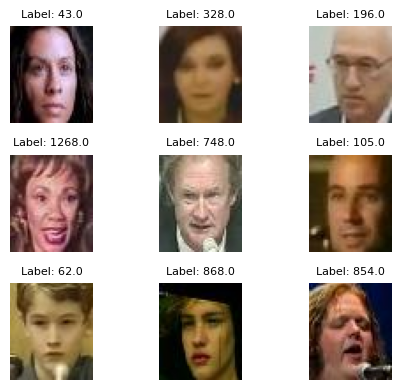

In [4]:
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(5, 4))
axes = axes.flatten()
for i in range(rows * cols):
    ax = axes[i]
    ax.imshow(cl_x_test[i]/255)
    ax.set_title(f"Label: {cl_y_test[i]}", fontsize = 8)
    ax.axis("off")
plt.tight_layout()
plt.show()

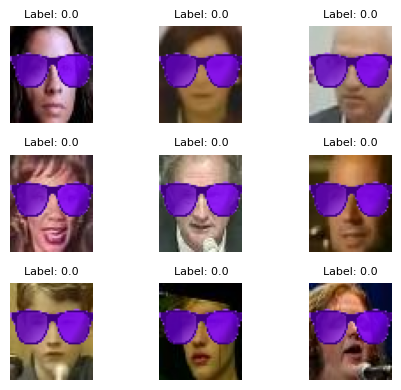

In [5]:
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(5, 4))
axes = axes.flatten()
for i in range(rows * cols):
    ax = axes[i]
    ax.imshow(bd_x_test[i]/255)
    ax.set_title(f"Label: {bd_y_test[i]}", fontsize = 8)
    ax.axis("off")
plt.tight_layout()
plt.show()

### Model Summary

In [6]:
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

### Pruning Defense
The general idea is to prune the neural network and compare its performance with the original network to detect any discrepancies caused by the presence of a backdoor. We recall that backdoors activated unues/spare neurons in the network.

The pruning defense works as follows: the defender exercises the DNN received from the attacker with clean inputs from the validation dataset, Dvalid, and records the average activation of each neuron. The defender then iteratively prunes neurons from the DNN in increasing order of average activations and records the accuracy of the pruned network in each iteration. The defense terminates when the accuracy on the validation dataset drops below a pre-determined threshold

In [7]:
model_weights = './model/bd_weights.h5'
bd_model.load_weights(model_weights)

cloned_model= keras.models.clone_model(bd_model)
cloned_model.set_weights(bd_model.get_weights())

'sorted_channels' contains the indices of the channels of the 'pool_3' layer sorted in increasing order of their mean activation values

In [8]:
cl_accuracy=98.64899974019225

pooling_layer = cloned_model.get_layer('pool_3').output
intermediate_model = keras.models.Model(inputs=cloned_model.input, outputs=pooling_layer) #create a new intermediate model that takes same input as
#cloned_model but has output as pooling layer
intermediate_predictions = intermediate_model.predict(cl_x_test)

# get average activation values
average_activations = np.mean(intermediate_predictions, axis=(0, 1, 2))
sorted_channels = np.argsort(average_activations)

pruned_clean_accuracies = []
attack_success_rates = []
pruning_degree=[]
saved_models = np.zeros(3, dtype=bool)
pruned_weights = cloned_model.layers[5].get_weights()[0]
pruned_biases = cloned_model.layers[5].get_weights()[1]

for pruned_channel_index in tqdm(sorted_channels):
    # Prune the channel
    # pruned_weights, pruned_biases = cloned_model.get_layer('pool_3').get_weights()
    pruned_weights[:, :, :, pruned_channel_index] = 0
    pruned_biases[pruned_channel_index] = 0
    cloned_model.layers[5].set_weights([pruned_weights, pruned_biases])

    # Evaluate clean accuracy
    pruned_clean_predictions = cloned_model.predict(cl_x_test)
    pruned_clean_labels = np.argmax(pruned_clean_predictions, axis=1)
    pruned_clean_accuracy = np.mean(np.equal(pruned_clean_labels, cl_y_test)) * 100

    # Check for accuracy drop and save the model
    for i, accuracy_drop_threshold in enumerate([2, 4, 10]):
        if (cl_accuracy - pruned_clean_accuracy >= accuracy_drop_threshold and not saved_models[i]):
            print(f"The accuracy drops at least {accuracy_drop_threshold}%, saved the model")
            cloned_model.save(f'model_X={accuracy_drop_threshold}.h5')
            saved_models[i] = True

    # Append results
    pruned_clean_accuracies.append(pruned_clean_accuracy)
    attack_success_rate = np.mean(np.equal(np.argmax(cloned_model.predict(bd_x_test), axis=1), bd_y_test)) * 100
    attack_success_rates.append(attack_success_rate)
    pruning_degree.append(pruned_channel_index)

    # Print results
    print()
    print("The pruned clean accuracy is: ", pruned_clean_accuracy)
    print("The attack success rate is: ", attack_success_rate)
    print("The pruned channel index is: ", pruned_channel_index)

    # Clear the Keras session
    keras.backend.clear_session()

 24/361 [>.............................] - ETA: 1s

2023-11-28 11:49:30.220448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

 25/361 [=>............................] - ETA: 1s

2023-11-28 11:49:32.577669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0


  2%|▏         | 1/60 [00:05<05:06,  5.20s/it]

 23/361 [>.............................] - ETA: 1s

2023-11-28 11:49:38.144668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 5ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26


  3%|▎         | 2/60 [00:10<05:10,  5.36s/it]

 25/361 [=>............................] - ETA: 1s

2023-11-28 11:49:43.782747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27


  5%|▌         | 3/60 [00:16<05:13,  5.51s/it]

 11/361 [..............................] - ETA: 1s 

2023-11-28 11:49:49.309124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


  7%|▋         | 4/60 [00:21<05:07,  5.49s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30
 11/361 [..............................] - ETA: 1s 

2023-11-28 11:49:54.715058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step


  8%|▊         | 5/60 [00:26<04:55,  5.38s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31
 12/361 [..............................] - ETA: 1s 

2023-11-28 11:50:00.056249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 5ms/step


 10%|█         | 6/60 [00:32<05:01,  5.58s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33
 11/361 [..............................] - ETA: 1s 

2023-11-28 11:50:06.816448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34


 12%|█▏        | 7/60 [00:41<05:39,  6.41s/it]

 11/361 [..............................] - ETA: 1s 

2023-11-28 11:50:14.037323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 7ms/step


 13%|█▎        | 8/60 [00:49<06:00,  6.93s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36
 12/361 [..............................] - ETA: 1s 

2023-11-28 11:50:22.584454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 5ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37


 15%|█▌        | 9/60 [00:56<06:04,  7.14s/it]

 11/361 [..............................] - ETA: 1s 

2023-11-28 11:50:30.710092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 8ms/step


 17%|█▋        | 10/60 [01:06<06:36,  7.94s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38
 12/361 [..............................] - ETA: 1s 

2023-11-28 11:50:39.579900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 5ms/step


 18%|█▊        | 11/60 [01:12<06:05,  7.47s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25
 12/361 [..............................] - ETA: 1s 

2023-11-28 11:50:45.909157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 7ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39


 20%|██        | 12/60 [01:21<06:15,  7.82s/it]

 10/361 [..............................] - ETA: 2s 

2023-11-28 11:50:54.414006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 7ms/step


 22%|██▏       | 13/60 [01:28<05:57,  7.61s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41
 12/361 [..............................] - ETA: 1s 

2023-11-28 11:51:01.479827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44


 23%|██▎       | 14/60 [01:33<05:15,  6.85s/it]

 12/361 [..............................] - ETA: 1s 

2023-11-28 11:51:06.804803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 25%|██▌       | 15/60 [01:39<05:00,  6.67s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45
 10/361 [..............................] - ETA: 2s 

2023-11-28 11:51:12.803438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 7ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47


 27%|██▋       | 16/60 [01:46<04:54,  6.68s/it]

  1/361 [..............................] - ETA: 1:09

2023-11-28 11:51:19.594410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step


 28%|██▊       | 17/60 [01:51<04:22,  6.12s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48
  8/361 [..............................] - ETA: 2s 

2023-11-28 11:51:24.270113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 30%|███       | 18/60 [01:58<04:24,  6.29s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
 10/361 [..............................] - ETA: 2s 

2023-11-28 11:51:31.062238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 8ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50


 32%|███▏      | 19/60 [02:05<04:30,  6.59s/it]2023-11-28 11:51:38.422672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 33%|███▎      | 20/60 [02:11<04:16,  6.42s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53
 18/361 [>.............................] - ETA: 2s

2023-11-28 11:51:44.581031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 7ms/step


 35%|███▌      | 21/60 [02:19<04:27,  6.86s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55
  9/361 [..............................] - ETA: 2s 

2023-11-28 11:51:52.529802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 37%|███▋      | 22/60 [02:26<04:23,  6.93s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40


2023-11-28 11:51:59.370162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 7ms/step


 38%|███▊      | 23/60 [02:34<04:27,  7.24s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24
 10/361 [..............................] - ETA: 2s 

2023-11-28 11:52:07.376800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step



 40%|████      | 24/60 [02:41<04:18,  7.19s/it]

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59
 10/361 [..............................] - ETA: 2s 

2023-11-28 11:52:14.340358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9


 42%|████▏     | 25/60 [02:48<04:05,  7.01s/it]2023-11-28 11:52:21.014312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 7ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2


 43%|████▎     | 26/60 [02:54<03:52,  6.85s/it]

 10/361 [..............................] - ETA: 2s 

2023-11-28 11:52:27.392298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 45%|████▌     | 27/60 [03:02<03:51,  7.03s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12
 10/361 [..............................] - ETA: 2s 

2023-11-28 11:52:34.811601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 8ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13


 47%|████▋     | 28/60 [03:09<03:49,  7.17s/it]2023-11-28 11:52:42.833055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17


 48%|████▊     | 29/60 [03:17<03:51,  7.46s/it]

  1/361 [..............................] - ETA: 1:04

2023-11-28 11:52:50.819153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 5s 13ms/step


 50%|█████     | 30/60 [03:32<04:49,  9.65s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14


2023-11-28 11:53:06.769883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 9ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15


 52%|█████▏    | 31/60 [03:44<05:00, 10.35s/it]2023-11-28 11:53:17.596745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 7ms/step

The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23


 53%|█████▎    | 32/60 [03:52<04:29,  9.61s/it]

 10/361 [..............................] - ETA: 2s 

2023-11-28 11:53:25.212902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 55%|█████▌    | 33/60 [03:59<03:59,  8.85s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6
  9/361 [..............................] - ETA: 2s 

2023-11-28 11:53:32.180241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 4s 10ms/step


 57%|█████▋    | 34/60 [04:08<03:48,  8.80s/it]


The pruned clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51


2023-11-28 11:53:41.731281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 58%|█████▊    | 35/60 [04:15<03:31,  8.46s/it]


The pruned clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32
 10/361 [..............................] - ETA: 1s 

2023-11-28 11:53:48.869311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 7ms/step

The pruned clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22


 60%|██████    | 36/60 [04:23<03:15,  8.14s/it]

  1/361 [..............................] - ETA: 1:10

2023-11-28 11:53:56.195596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 9ms/step

The pruned clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21


 62%|██████▏   | 37/60 [04:31<03:08,  8.21s/it]2023-11-28 11:54:04.551769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 8ms/step


 63%|██████▎   | 38/60 [04:40<03:02,  8.31s/it]


The pruned clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20
  9/361 [..............................] - ETA: 2s 

2023-11-28 11:54:13.122782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 8ms/step

The pruned clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19


 65%|██████▌   | 39/60 [04:47<02:50,  8.11s/it]

  9/361 [..............................] - ETA: 2s 

2023-11-28 11:54:20.533978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 7ms/step

The pruned clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43


 67%|██████▋   | 40/60 [04:54<02:36,  7.84s/it]2023-11-28 11:54:27.989429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step

The pruned clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58


 68%|██████▊   | 41/60 [05:01<02:21,  7.46s/it]

  1/361 [..............................] - ETA: 1:18

2023-11-28 11:54:34.522637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 8ms/step



 70%|███████   | 42/60 [05:09<02:15,  7.55s/it]

The pruned clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3


2023-11-28 11:54:42.289540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 10ms/step


 72%|███████▏  | 43/60 [05:18<02:16,  8.05s/it]


The pruned clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42


2023-11-28 11:54:51.422307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 73%|███████▎  | 44/60 [05:25<02:02,  7.65s/it]


The pruned clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
  1/361 [..............................] - ETA: 1:10

2023-11-28 11:54:58.162060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step
The accuracy drops at least 2%, saved the model
361/361 [==============================] - 2s 6ms/step

The pruned clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29


 75%|███████▌  | 45/60 [05:32<01:51,  7.46s/it]

 10/361 [..............................] - ETA: 2s 

2023-11-28 11:55:04.976474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step

The pruned clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16


 77%|███████▋  | 46/60 [05:38<01:41,  7.22s/it]2023-11-28 11:55:11.710399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step

The pruned clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56


 78%|███████▊  | 47/60 [05:45<01:30,  6.96s/it]

  9/361 [..............................] - ETA: 2s 

2023-11-28 11:55:18.047347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step
The accuracy drops at least 4%, saved the model
361/361 [==============================] - 2s 6ms/step


 80%|████████  | 48/60 [05:52<01:23,  6.92s/it]


The pruned clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46
  9/361 [..............................] - ETA: 2s 

2023-11-28 11:55:24.822520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 82%|████████▏ | 49/60 [05:58<01:15,  6.89s/it]


The pruned clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5


2023-11-28 11:55:31.679271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 83%|████████▎ | 50/60 [06:05<01:07,  6.76s/it]


The pruned clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8
  9/361 [..............................] - ETA: 2s 

2023-11-28 11:55:38.304306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 85%|████████▌ | 51/60 [06:12<01:03,  7.00s/it]


The pruned clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11
  1/361 [..............................] - ETA: 1:00

2023-11-28 11:55:45.691066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 7ms/step
The accuracy drops at least 10%, saved the model
361/361 [==============================] - 2s 6ms/step

The pruned clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54


 87%|████████▋ | 52/60 [06:19<00:55,  7.00s/it]2023-11-28 11:55:52.735183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 88%|████████▊ | 53/60 [06:26<00:47,  6.76s/it]


The pruned clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10
 10/361 [..............................] - ETA: 2s 

2023-11-28 11:55:58.891546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 8ms/step


 90%|█████████ | 54/60 [06:33<00:42,  7.00s/it]


The pruned clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28


2023-11-28 11:56:06.519322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 7ms/step


 92%|█████████▏| 55/60 [06:42<00:37,  7.47s/it]


The pruned clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35


2023-11-28 11:56:15.067043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 93%|█████████▎| 56/60 [06:48<00:28,  7.09s/it]


The pruned clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18
  9/361 [..............................] - ETA: 2s 

2023-11-28 11:56:21.331781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step

The pruned clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4


 95%|█████████▌| 57/60 [06:55<00:21,  7.02s/it]

  1/361 [..............................] - ETA: 1:10

2023-11-28 11:56:28.173021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 3s 8ms/step


 97%|█████████▋| 58/60 [07:02<00:14,  7.18s/it]


The pruned clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7


2023-11-28 11:56:35.784970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 6ms/step


 98%|█████████▊| 59/60 [07:09<00:06,  6.99s/it]


The pruned clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52
  9/361 [..............................] - ETA: 2s 

2023-11-28 11:56:42.337884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 7ms/step

The pruned clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


100%|██████████| 60/60 [07:16<00:00,  7.27s/it]


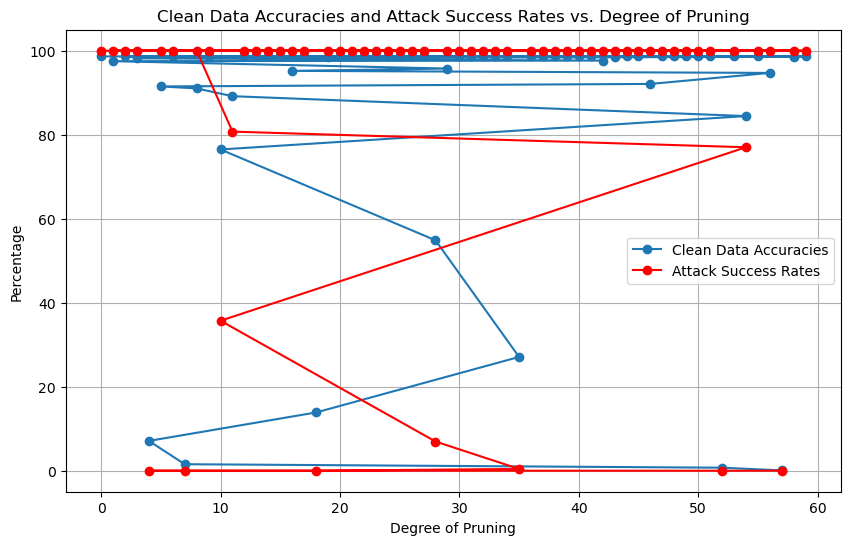

In [9]:
plt.figure(figsize=(10, 6))

plt.plot(pruning_degree, pruned_clean_accuracies, marker='o', label='Clean Data Accuracies')
plt.plot(pruning_degree, attack_success_rates, marker='o', color='red', label='Attack Success Rates')

plt.title('Clean Data Accuracies and Attack Success Rates vs. Degree of Pruning')
plt.xlabel('Degree of Pruning')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Accuracy and attack success rate for validation dataset')

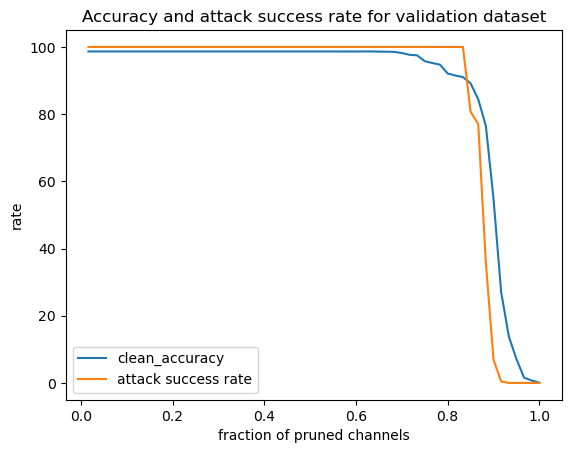

In [18]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,pruned_clean_accuracies)
plt.plot(x_axis,attack_success_rates)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("Accuracy and attack success rate for validation dataset")

## BadNet + GoodNet
Now that we have our goodnet, we can combine it with the badnet and check predictions. 

In [11]:
clean_test_filename = './data/cl/test.h5'
poisoned_test_filename = './data/bd/bd_test.h5'

In [12]:
cl_x_test, cl_y_test = data_loader(clean_test_filename)
bd_x_test, bd_y_test = data_loader(poisoned_test_filename)

In [13]:
# file paths 
drop_10 = './model_X=10.h5'
drop_4 = './model_X=2.h5'
drop_2 = './model_X=4.h5'
# load models
model_drop_10 = keras.models.load_model(drop_10)
model_drop_4 = keras.models.load_model(drop_4)
model_drop_2 = keras.models.load_model(drop_2)

In [14]:
print(len(set(cl_y_test)))

1283


The dataset has 1283 different classes, therefore we will keep N+1 as 1284

### Get Goodnet Predictions
Pass as arguments the BadNet, Pruned models with X={2,4,10}% and clean test data

In [15]:
def predict_combined(model1,model2,data):
    #get predictions
    pred_model1= np.argmax(model1(data), axis=1)
    pred_model2= np.argmax(model2(data), axis=1)
    predictions = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        if pred_model1[i]==pred_model2[i]:
          predictions[i] = pred_model1[i]
        else:
          predictions[i] = 1284
    return predictions


### Get Goodnet Accuracy and Attack Success Rate 

In [16]:
def get_accuracy_and_asr(goodnet):
    # to get accuracy predict on clean data
    goodnet_cl_pred = predict_combined(bd_model,goodnet,cl_x_test)
    accuracy = np.mean(np.equal(goodnet_cl_pred, cl_y_test))*100

    # to get asr predict on adverserial data
    goodnet_bd_pred = predict_combined(bd_model,goodnet,bd_x_test)
    asr = np.mean(np.equal(goodnet_bd_pred, bd_y_test))*100

    return accuracy,asr

### Test Goodness of GoodNets

In [21]:
g_accuracy_10, g_asr_10 = get_accuracy_and_asr(model_drop_10)
print(f'Goodnet with 10% drop in accuracy has accuracy {g_accuracy_10} and attack success rate {g_asr_10}\n\n')

g_accuracy_4, g_asr_4 = get_accuracy_and_asr(model_drop_4)
print(f'Goodnet with 4% drop in accuracy has accuracy {g_accuracy_4} and attack success rate {g_asr_4}\n\n')

g_accuracy_2, g_asr_2 = get_accuracy_and_asr(model_drop_2)
print(f'Goodnet with 2% drop in accuracy has accuracy {g_accuracy_2} and attack success rate {g_asr_2}\n\n')

Goodnet with 10% drop in accuracy has accuracy 84.3335931410756 and attack success rate 77.20966484801247


Goodnet with 4% drop in accuracy has accuracy 95.74434918160561 and attack success rate 100.0


Goodnet with 2% drop in accuracy has accuracy 92.1278254091972 and attack success rate 99.98441153546376




### Comparing Pruned Models and GoodNet Models
In this section we are conducting a thorough comparison of both the accuracy levels and attack success rates between our pruned models with a specified X% drop in accuracy and our consolidated GoodNets.

In [25]:
def get_accuracy_and_asr_pruned(model):
    pruned_cl_pred = np.argmax(model.predict(cl_x_test), axis=1)
    accuracy = np.mean(np.equal(pruned_cl_pred, cl_y_test))*100

    pruned_bd_pred = np.argmax(model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(pruned_bd_pred, bd_y_test))*100

    return accuracy,asr

In [26]:
p_accuracy_10, p_asr_10 = get_accuracy_and_asr_pruned(model_drop_10)
print(f'Pruned network with 10% drop in accuracy has accuracy {p_accuracy_10} and attack success rate {p_asr_10}\n\n')

p_accuracy_4, p_asr_4 = get_accuracy_and_asr_pruned(model_drop_4)
print(f'Pruned network with 4% drop in accuracy has accuracy {p_accuracy_4} and attack success rate {p_asr_4}\n\n')

p_accuracy_2, p_asr_2 = get_accuracy_and_asr_pruned(model_drop_2)
print(f'Pruned network with 2% drop in accuracy has accuracy {p_accuracy_2} and attack success rate {p_asr_2}\n\n')

401/401 [==============================] - 2s 5ms/step
Pruned network with 10% drop in accuracy has accuracy 84.54403741231489 and attack success rate 77.20966484801247




2023-11-28 12:24:29.220822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


401/401 [==============================] - 2s 5ms/step
Pruned network with 4% drop in accuracy has accuracy 95.90023382696803 and attack success rate 100.0


  1/401 [..............................] - ETA: 1:37

2023-11-28 12:24:35.469485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


401/401 [==============================] - 2s 4ms/step
Pruned network with 2% drop in accuracy has accuracy 92.29150428682775 and attack success rate 99.98441153546376




Therefore we see that our Goodnets perform comparable to the pruned models